# ASL Action Recognition

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/05-asl-action-recognition.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/05-asl-action-recognition.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/raw/master/tutorials/05-asl-action-recognition.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

### Start EVA server
We are reusing the start server notebook for launching the EVA server

In [1]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File '00-start-eva-server.ipynb' already there; not retrieving.



Note: you may need to restart the kernel to use updated packages.


Starting EVA Server ...
nohup eva_server --port 8804 > eva.log 2>&1 &


In [2]:
!wget -nc "https://www.dropbox.com/s/ti7ptv0gftbk5ji/computer_asl.mp4?dl=0" -O computer_asl.mp4

#ASL UDF
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/eva/udfs/asl_action_recognition.py -O asl_action_recognition.py 

#Pickle file containing the mapping of the ASL action to index
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/eva/udfs/asl_20_actions_map.pkl -O asl_20_actions_map.pkl

File 'computer_asl.mp4' already there; not retrieving.


File 'asl_action_recognition.py' already there; not retrieving.


File 'asl_20_actions_map.pkl' already there; not retrieving.


### Adding the video file to EVADB for analysis

In [3]:
response = cursor.execute("DROP TABLE IF EXISTS ASL_ACTIONS;").fetch_all().as_df()
cursor.execute('LOAD VIDEO "computer_asl.mp4" INTO ASL_ACTIONS;').fetch_all().as_df()


,0
0,Number of loaded VIDEO: 1


### Visualize the video

In [4]:
from IPython.display import Video
Video("computer_asl.mp4", height=450, width=800, embed=True)

### Create an user-defined function(UDF) for analyzing the frames

In [5]:
cursor.execute("DROP UDF IF EXISTS ASLActionRecognition;").fetch_all().as_df()
cursor.execute("""CREATE UDF IF NOT EXISTS ASLActionRecognition
        INPUT  (Frame_Array NDARRAY UINT8(3, 16, 224, 224))
        OUTPUT (labels NDARRAY STR(ANYDIM))
        TYPE  Classification
        IMPL  'asl_action_recognition.py'
        """).fetch_all().as_df()

,0
0,UDF ASLActionRecognition successfully added to...


### Run the UDF on the Video to find the ASL action

In [6]:
response = cursor.execute("""SELECT FIRST(id), ASLActionRecognition(SEGMENT(data)) 
                  FROM ASL_ACTIONS 
                  SAMPLE 5
                  GROUP BY '16f';""").fetch_all().as_df()

In [7]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    label = detections['aslactionrecognition.labels'][0]
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read() 

    while ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        x1, y1, x2, y2 = 350, 100, 900, 500
        # object bbox
        frame=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
        # object label
        cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness)
        
        # frame label
        cv2.putText(frame, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness) 
    
        video.write(frame)
        # Show every twentieth frame
        if frame_id % 20 == 0:
            plt.imshow(frame)
            plt.show()
    
        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

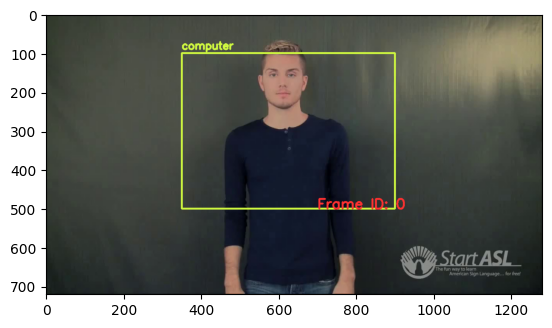

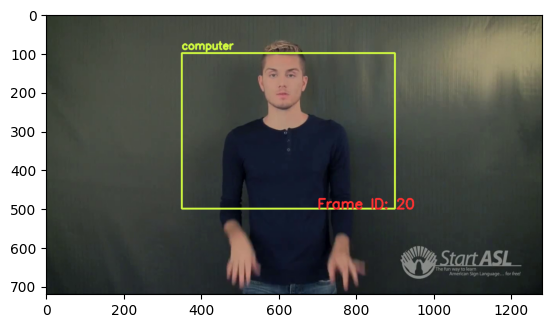

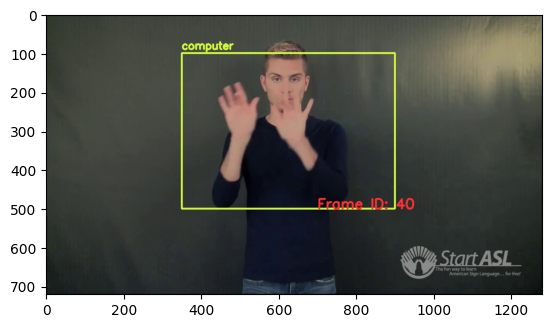

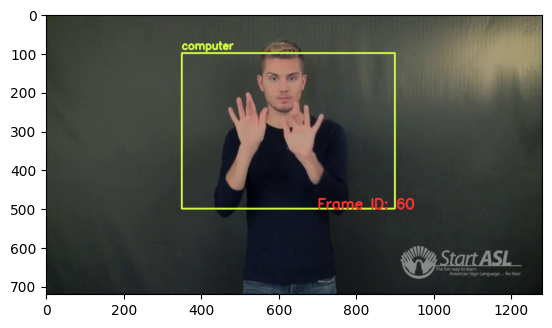

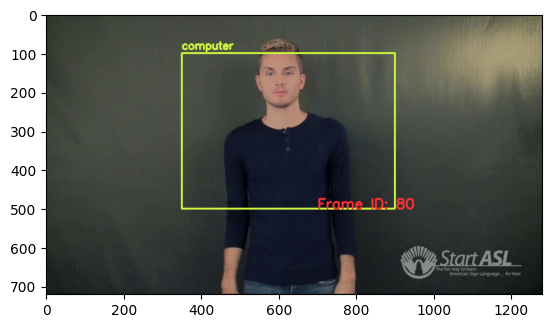

In [8]:
input_path = 'computer_asl.mp4'
output_path = 'computer_annotated.mp4'

annotate_video(response, input_path, output_path)